# Predicting Player Engagement: A Regression Analysis of Age, Gender, and Experience on Total Session Time
## DSCI 100 007 - Group 9 Final Report  
`Members:` Alana Duan, Eva Jiang, Lucia Song, and Leo Wang  
`Date:` April 5th, 2025

# Introduction

Understanding what drives player engagement is essential for designing games that retain users and offer personalized experiences. One widely used measure of engagement is **total session time**, which reflects how long a player actively interacts with the game. Game developers and researchers alike benefit from knowing which user attributes predict longer play times.

In this project, we aim to answer the following question:

**Can age, gender, and experience level predict total session time per player?**

To explore this, we use data provided by a UBC Computer Science research group studying player behavior in a custom Minecraft server environment. The data consist of two files:  
- `players.csv` contains demographic and background information for each unique player, including variables such as age, gender, and self-reported experience level.  
- `sessions.csv` records individual play sessions, including session duration and player identifiers.

We merge these datasets using a unique identifier and compute the total session time for each player by aggregating their individual session durations. After performing data cleaning and preprocessing to remove missing or inconsistent entries, we apply a multiple linear regression model to analyze how age, gender, and experience level relate to total play time. The model is evaluated using metrics such as R-squared and root mean square error (RMSE), and the coefficients are interpreted to determine the strength and direction of each predictor's effect.

In [1]:
# LOAD PACKAGES
library(tidyverse)
library(janitor) # for clean_names
library(repr)
library(infer)
library(cowplot)
options(repr.matrix.max.rows = 6,
        repr.plot.width = 10,
        repr.plot.height = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




# Methods & Results

* describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
* your report should include code which:
    * loads data
    * wrangles and cleans the data to the format necessary for the planned analysis
    * performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
    * creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    * performs the data analysis
    * creates a visualization of the analysis 
    * *note: all figures should have a figure number and a legend*

In [2]:
# Load players data
players <- url("https://raw.githubusercontent.com/arevaura/dsci-100-2024w2-group-9/refs/heads/main/data/players.csv") |>
    read_csv() |>
    clean_names()
head(players, n=5)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21


In [3]:
# Load sessions data
sessions_raw <- url("https://raw.githubusercontent.com/arevaura/dsci-100-2024w2-group-9/refs/heads/main/data/sessions.csv") |>
    read_csv() |>
    clean_names()
head(sessions_raw, n=5)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashed_email,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12


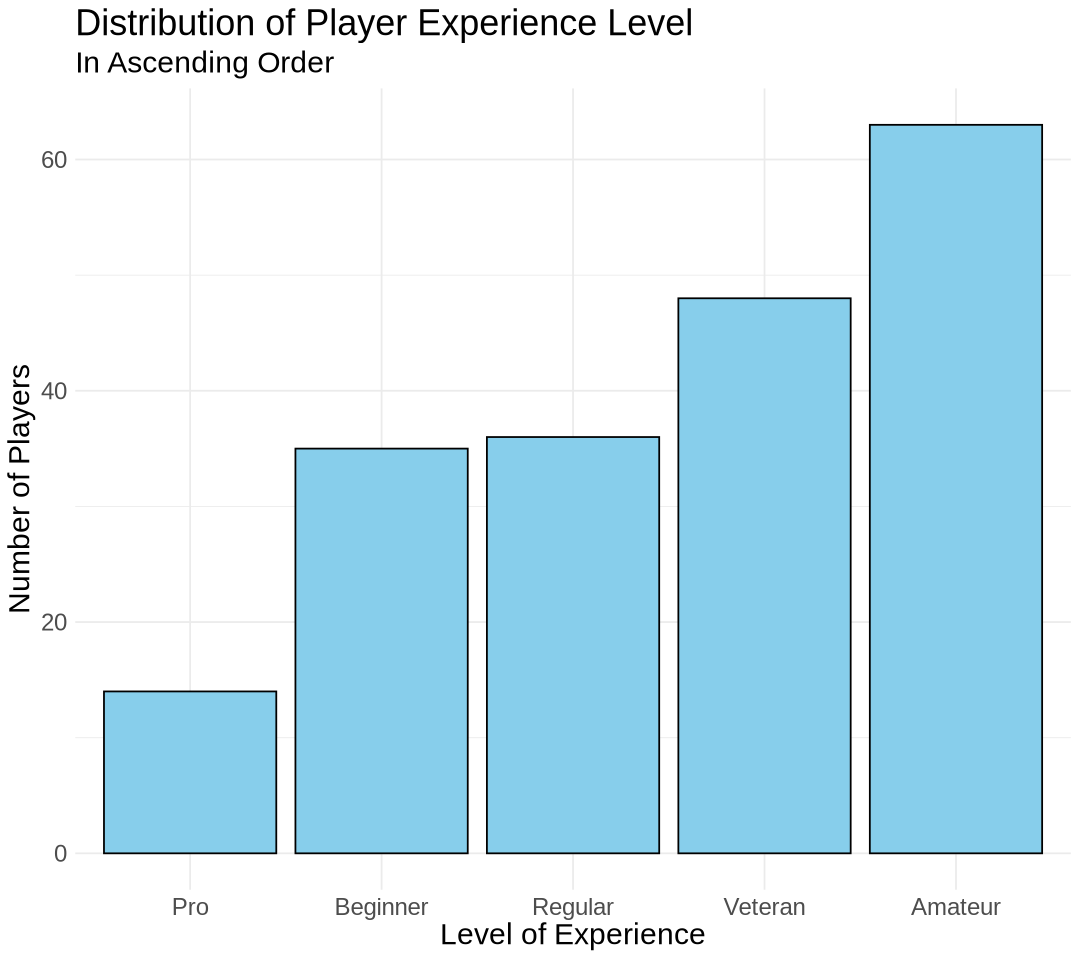

In [24]:
experience_level_plot <- players |>
    count(experience) |>
    ggplot(aes(x = fct_reorder(experience, n), y=n)) +
        geom_bar(stat="identity", fill = "skyblue", color = "black") +
        labs(x = "Level of Experience", 
             y = "Number of Players", 
             title = "Distribution of Player Experience Level",
             subtitle = "In Ascending Order") + 
        theme_minimal() +
        theme(text = element_text(size = 18))
options(repr.plot.width = 9)
experience_level_plot

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


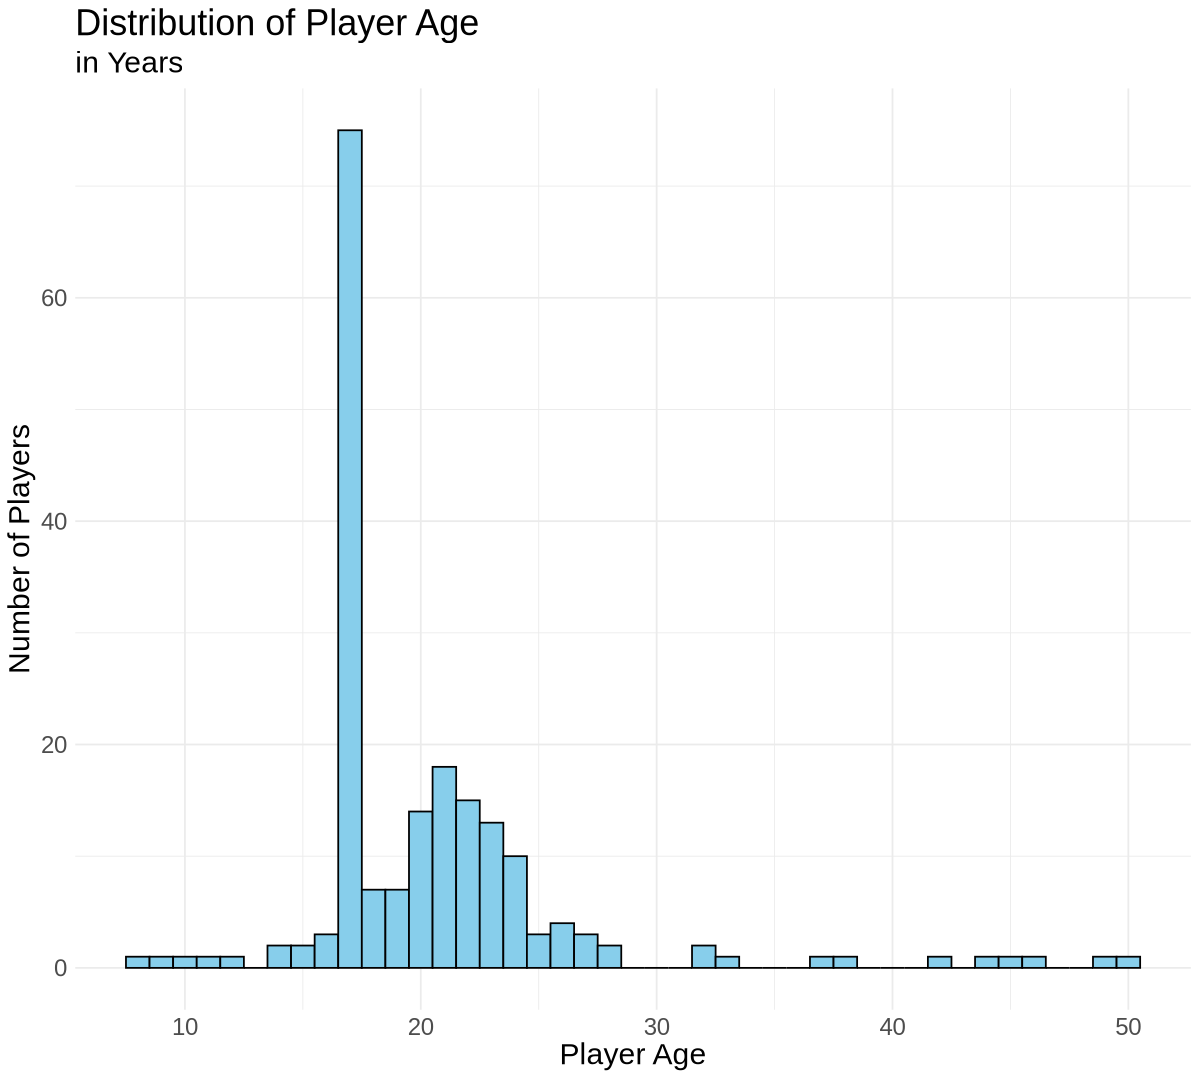

In [46]:
age_plot <- players |> 
    ggplot(aes(x = age)) +
        geom_histogram(binwidth = 1, fill = "skyblue", color = "black") +
        labs(x = "Player Age", 
             y = "Number of Players", 
             title = "Distribution of Player Age",
             subtitle = "in Years") +
        theme_minimal() +
        theme(text = element_text(size = 18))
options(repr.plot.width = 10, repr.plot.height = 9)
age_plot

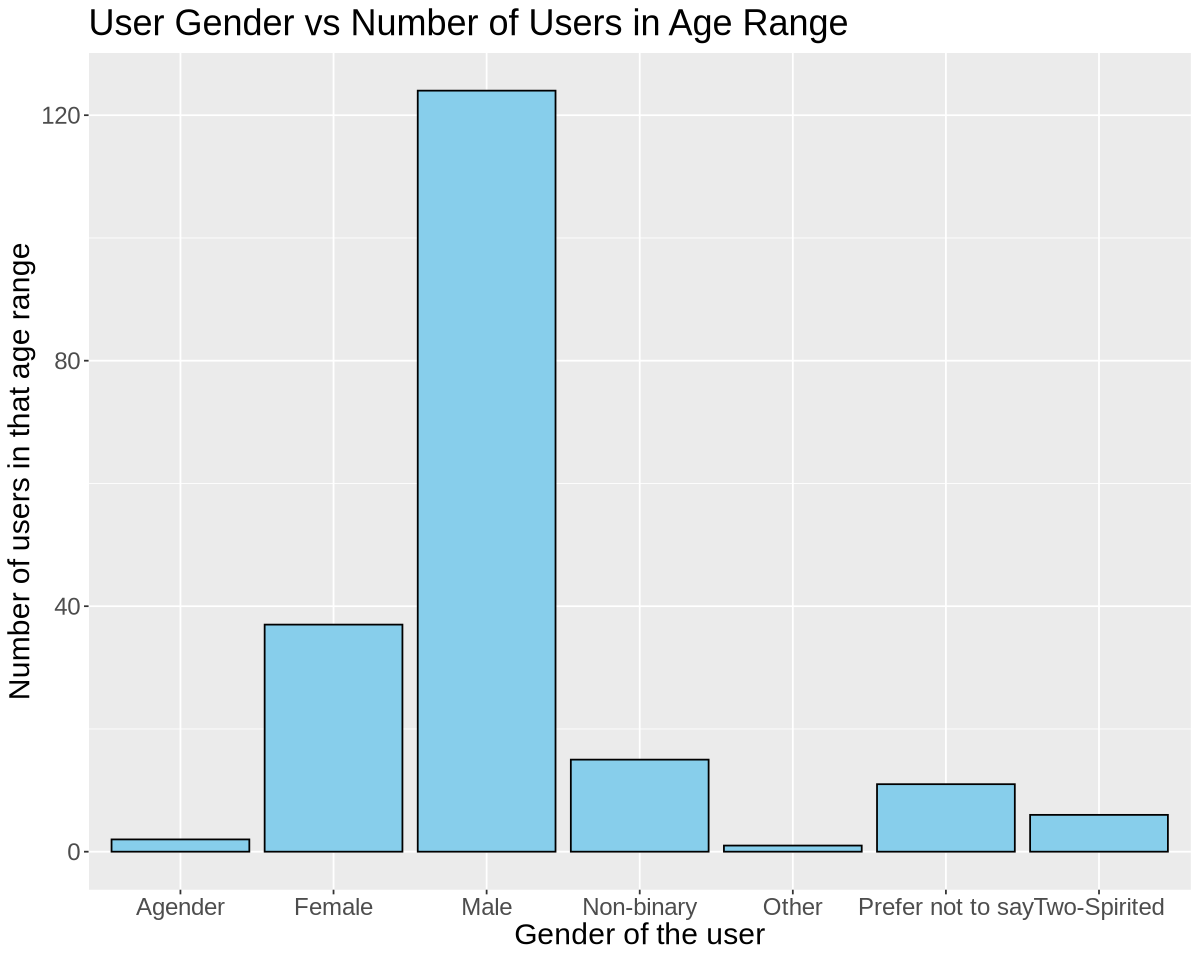

In [6]:
gender_plot <- players |>
    ggplot(aes(x = gender)) +
        geom_bar(fill = "skyblue", color = "black") +
        labs(x = "Gender of the user", 
             y = "Number of users in that age range", 
             title = "User Gender vs Number of Users in Age Range") +
        theme_minimal() +
        theme(text = element_text(size = 18))
gender_plot

# Discussion

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

# References

* You may include references if necessary, as long as they all have a consistent citation style.